In [1]:
import pandas as pd
import numpy as np
import glob

In [2]:
trainset_original = pd.read_csv("../backup/application_train.csv")
val_nn = pd.read_csv("./submission_custom_val/nn_submission_custom_val.csv")
val_lightgbm = pd.read_csv("./submission_custom_val/lightGBM_custom_val.csv")
val_embed = pd.read_csv("./submission_custom_val/nn_embedding_custom_val_submission.csv")
val_catboost =pd.read_csv("./submission_custom_val/submission_catboost_custom_val.csv")

In [3]:
#select correct columns from trainset
true_target_df = trainset_original.loc[trainset_original['SK_ID_CURR'].isin(val_nn["SK_ID_CURR"])]
target_df = pd.DataFrame({"SK_ID_CURR":true_target_df["SK_ID_CURR"], "TRUE_TARGET": true_target_df["TARGET"]})

rename set columns for merging

In [4]:
val_nn.rename(columns={"TARGET":"TARGET_NN"},inplace=True)
val_lightgbm.rename(columns={"TARGET":"TARGET_LIGHTGBM"},inplace=True)
val_embed.rename(columns={"TARGET":"TARGET_EMBEDDED"},inplace=True)
val_catboost.rename(columns={"TARGET":"TARGET_CATBOOST"},inplace=True)


now merge all dataframes

In [5]:
dflist = [val_nn, val_lightgbm, val_embed, val_catboost]
for i in range(4):
    if i == 0:
        mergedDF = pd.merge(target_df, dflist[i], on="SK_ID_CURR")
    else:
        mergedDF = pd.merge(mergedDF, dflist[i], on="SK_ID_CURR")

In [6]:
col = mergedDF.loc[: , "TARGET_NN":"TARGET_CATBOOST"]
mergedDF["TARGET_COMBINED"] = col.mean(axis=1)
mergedDF

,SK_ID_CURR,TRUE_TARGET,TARGET_NN,TARGET_LIGHTGBM,TARGET_EMBEDDED,TARGET_CATBOOST,TARGET_COMBINED
0,100004,0,0.241646,0.028919,0.020899,0.159091,0.112639
1,100008,0,0.379759,0.036442,0.068984,0.165002,0.162547
2,100010,0,0.129853,0.013891,0.016203,0.063249,0.055799
3,100012,0,0.380836,0.041014,0.032973,0.178147,0.158243
4,100018,0,0.198752,0.013130,0.010937,0.056736,0.069889
...,...,...,...,...,...,...,...
61405,456206,0,0.436016,0.016267,0.033523,0.081942,0.141937
61406,456208,0,0.488201,0.021677,0.041311,0.174505,0.181424
61407,456241,0,0.284531,0.063375,0.035232,0.172515,0.138913
61408,456243,0,0.371694,0.025139,0.032014,0.069002,0.124462


In [7]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

collist = ["TARGET_NN", "TARGET_LIGHTGBM", "TARGET_EMBEDDED", "TARGET_CATBOOST", "TARGET_COMBINED"]
target = "TRUE_TARGET"

fpr = dict()
tpr = dict()
roc_auc = dict()

for i, col in enumerate(collist):
    fpr[i], tpr[i], _ = roc_curve(mergedDF[target].values, mergedDF[col].values)
    roc_auc[i] = auc(fpr[i], tpr[i])

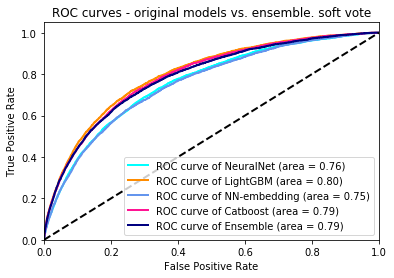

In [8]:
lw = 2
modellist = ["NeuralNet", "LightGBM", "NN-embedding", "Catboost", "Ensemble"]
colors = cycle(['aqua', 'darkorange', 'cornflowerblue' , 'deeppink', 'navy'])
for i, color in zip(range(len(modellist)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(modellist[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves - original models vs. ensemble. soft vote')
plt.legend(loc="lower right")
plt.savefig("roc_all.png")
plt.show()



In [9]:
plt.savefig("roc_all.png")

<Figure size 432x288 with 0 Axes>

let's do hard voting next:

In [10]:
mergedDF["TARGET_NN"][mergedDF["TARGET_NN"] > 0.5] = 1
mergedDF["TARGET_NN"][mergedDF["TARGET_NN"] <= 0.5] = 0
mergedDF

/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SK_ID_CURR,TRUE_TARGET,TARGET_NN,TARGET_LIGHTGBM,TARGET_EMBEDDED,TARGET_CATBOOST,TARGET_COMBINED
0,100004,0,0.0,0.028919,0.020899,0.159091,0.112639
1,100008,0,0.0,0.036442,0.068984,0.165002,0.162547
2,100010,0,0.0,0.013891,0.016203,0.063249,0.055799
3,100012,0,0.0,0.041014,0.032973,0.178147,0.158243
4,100018,0,0.0,0.013130,0.010937,0.056736,0.069889
...,...,...,...,...,...,...,...
61405,456206,0,0.0,0.016267,0.033523,0.081942,0.141937
61406,456208,0,0.0,0.021677,0.041311,0.174505,0.181424
61407,456241,0,0.0,0.063375,0.035232,0.172515,0.138913
61408,456243,0,0.0,0.025139,0.032014,0.069002,0.124462


In [11]:
collist_hard = ["TARGET_NN", "TARGET_LIGHTGBM", "TARGET_EMBEDDED", "TARGET_CATBOOST"]
for i in collist_hard:
    mergedDF[i][mergedDF[i] > 0.5] = 1
    mergedDF[i][mergedDF[i] <= 0.5] = 0
mergedDF

/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,SK_ID_CURR,TRUE_TARGET,TARGET_NN,TARGET_LIGHTGBM,TARGET_EMBEDDED,TARGET_CATBOOST,TARGET_COMBINED
0,100004,0,0.0,0.0,0.0,0.0,0.112639
1,100008,0,0.0,0.0,0.0,0.0,0.162547
2,100010,0,0.0,0.0,0.0,0.0,0.055799
3,100012,0,0.0,0.0,0.0,0.0,0.158243
4,100018,0,0.0,0.0,0.0,0.0,0.069889
...,...,...,...,...,...,...,...
61405,456206,0,0.0,0.0,0.0,0.0,0.141937
61406,456208,0,0.0,0.0,0.0,0.0,0.181424
61407,456241,0,0.0,0.0,0.0,0.0,0.138913
61408,456243,0,0.0,0.0,0.0,0.0,0.124462


In [12]:
col = mergedDF.loc[: , "TARGET_NN":"TARGET_CATBOOST"]
mergedDF["TARGET_COMBINED"] = col.mean(axis=1)
mergedDF

,SK_ID_CURR,TRUE_TARGET,TARGET_NN,TARGET_LIGHTGBM,TARGET_EMBEDDED,TARGET_CATBOOST,TARGET_COMBINED
0,100004,0,0.0,0.0,0.0,0.0,0.0
1,100008,0,0.0,0.0,0.0,0.0,0.0
2,100010,0,0.0,0.0,0.0,0.0,0.0
3,100012,0,0.0,0.0,0.0,0.0,0.0
4,100018,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
61405,456206,0,0.0,0.0,0.0,0.0,0.0
61406,456208,0,0.0,0.0,0.0,0.0,0.0
61407,456241,0,0.0,0.0,0.0,0.0,0.0
61408,456243,0,0.0,0.0,0.0,0.0,0.0


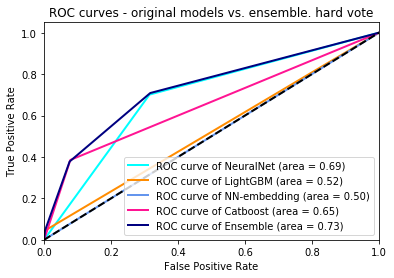

In [13]:
collist = ["TARGET_NN", "TARGET_LIGHTGBM", "TARGET_EMBEDDED", "TARGET_CATBOOST", "TARGET_COMBINED"]
target = "TRUE_TARGET"

fpr = dict()
tpr = dict()
roc_auc = dict()

for i, col in enumerate(collist):
    fpr[i], tpr[i], _ = roc_curve(mergedDF[target].values, mergedDF[col].values)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
lw = 2
modellist = ["NeuralNet", "LightGBM", "NN-embedding", "Catboost", "Ensemble"]
colors = cycle(['aqua', 'darkorange', 'cornflowerblue' , 'deeppink', 'navy'])
for i, color in zip(range(len(modellist)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(modellist[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves - original models vs. ensemble. hard vote')
plt.legend(loc="lower right")
plt.savefig("roc_hard.png")
plt.show()

